### imports

In [1]:
import glob
from shapely import wkt
from joblib import dump
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

### Upload Data

In [2]:
file_list = glob.glob("Data/raw_data/*.parquet")
df = pd.DataFrame(pd.read_parquet(file_list[0]))
for i in range(1,len(file_list)):
    new_df = pd.read_parquet(file_list[i])
    df = pd.concat([df,new_df],axis=0)

### Data Cleaning

**Read Main Data**

In [3]:
df.reset_index(drop=True, inplace=True)
df.columns = df.columns.str.lower()

**Read Taxi Zones Lookup Tables**

In [4]:
df_zone_coor = pd.read_csv("Data/taxi_zone_coordinates.csv")
df_zone_look = pd.read_csv("Data/taxi_zone_lookup.csv")

**Check_Variable_Descriptions**

In [5]:
variable_descriptions = {
    "vendorid": "1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.",
    "lpep_pickup_datetime": "The date and time when the meter was engaged.",
    "lpep_dropoff_datetime": "The date and time when the meter was disengaged.",
    "store_and_fwd_flag": "This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,”Y= store and forward trip, N= not a store and forward trip.",
    "ratecodeid": "The final rate code in effect at the end of the trip: 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride.",
    "pulocationid": "TLC Taxi Zone in which the taximeter was engaged.",
    "dolocationid": "TLC Taxi Zone in which the taximeter was disengaged.",
    "passenger_count": "The number of passengers in the vehicle (driver-entered value).",
    "trip_distance": "The elapsed trip distance in miles reported by the taximeter.",
    "fare_amount": "The time-and-distance fare calculated by the meter.",
    "extra": "Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.",
    "mta_tax": "$0.50 MTA tax that is automatically triggered based on the metered rate in use.",
    "tip_amount": "Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.",
    "tolls_amount": "Total amount of all tolls paid in trip",
    "improvement_surcharge": "$0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.",
    "total_amount": "The total amount charged to passengers. Does not include cash tips",
    "payment_type": "A numeric code signifying how the passenger paid for the trip: 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip",
    "trip_type": "A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver: 1= Street-hail, 2= Dispatch",
    "congestion_surcharge": "The surcharge is generally: $2.75 for each for-hire transportation trip in a vehicle that is not a medallion taxicab or a pool vehicle. $2.50 per trip when the transportation is provided by a medallion taxicab vehicle",
    "Airport_fee": "$1.25 for pick up only at LaGuardia and John F. Kennedy Airports"
}

In [6]:
df_column_description = pd.DataFrame(variable_descriptions, index=["Variable_description"]).T
with pd.option_context('display.max_colwidth', None):
  display(df_column_description)

,Variable_description
vendorid,"1= Creative Mobile Technologies, LLC; 2= VeriFone Inc."
lpep_pickup_datetime,The date and time when the meter was engaged.
lpep_dropoff_datetime,The date and time when the meter was disengaged.
store_and_fwd_flag,"This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,”Y= store and forward trip, N= not a store and forward trip."
ratecodeid,"The final rate code in effect at the end of the trip: 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride."
pulocationid,TLC Taxi Zone in which the taximeter was engaged.
dolocationid,TLC Taxi Zone in which the taximeter was disengaged.
passenger_count,The number of passengers in the vehicle (driver-entered value).
trip_distance,The elapsed trip distance in miles reported by the taximeter.
fare_amount,The time-and-distance fare calculated by the meter.


**Missin Values**

In [7]:
print(f"Dataframe Dimensions: {df.shape}")

Dataframe Dimensions: (767963, 20)


In [8]:
df.isnull().sum()

vendorid                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        83265
ratecodeid                83265
pulocationid                  0
dolocationid                  0
passenger_count           83265
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                767963
improvement_surcharge         0
total_amount                  0
payment_type              83265
trip_type                 83273
congestion_surcharge      83265
dtype: int64

* All values in column "ehail_fee" are missing
* There are 6 columns with around 83,265 missing values, so these records might be related: if one value is missing in a record, there might be high chance that other 6 problematic variable will be missing too.

**VendorID**

In [9]:
df.vendorid.value_counts()

2    658624
1    109332
5         7
Name: vendorid, dtype: int64

* According to Datasource, we should have value 1 or 2 in this column, so dropping these 7 observations should be appropriate choice.

**store_and_fwd_flag**

In [10]:
df.store_and_fwd_flag.value_counts()

N    678150
Y      6548
Name: store_and_fwd_flag, dtype: int64

* Seems "not a store and forward trip" class dominates

**ratecodeid**

In [11]:
df.ratecodeid.value_counts()

1.0     643446
5.0      37305
2.0       2714
4.0        715
3.0        503
99.0         8
6.0          7
Name: ratecodeid, dtype: int64

* Maximum is 6, so we should drop there 8 records with value "99"

**pulocationid** & **dolocationid**

In [12]:
print(f"Minimum index of Zone in lookup table: {df_zone_look.LocationID.min()}, Maximum: {df_zone_look.LocationID.max()}")
print(f"Minimum index of Zone main dataframe (pulocationid): {df.pulocationid.min()}, Maximum: {df.pulocationid.max()}")
print(f"Minimum index of Zone main dataframe (dolocationid): {df.dolocationid.min()}, Maximum: {df.dolocationid.max()}")

Minimum index of Zone in lookup table: 1, Maximum: 265
Minimum index of Zone main dataframe (pulocationid): 1, Maximum: 265
Minimum index of Zone main dataframe (dolocationid): 1, Maximum: 265


* Seems there are no numerical errors in these columns
* Although there is one issue: there are no information about 264 & 265 sectors in lookup table, seems it's newly added zones. duo to lack of information, let's remove observations assocciated with these zones from our dataset

**passenger_count**

In [13]:
df.passenger_count.value_counts()

1.0    585786
2.0     58042
5.0     13929
6.0     10851
3.0      9801
0.0      3117
4.0      2987
8.0        91
7.0        64
9.0        30
Name: passenger_count, dtype: int64

* According to law, 6 is maximum number of passengers (four adult with less than 7 years 2 child), so probably removing observations with values 7, 8 and 9 should be appropriate choice.

**pickup_datetime** & **dropoff_datetime**

In [14]:
# firstly let's generate new variable which shows trip time 
df["trip_time"] = round((df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.seconds / 60, 2)

In [15]:
# according to NYC Taxi law, passenger have to pay 30$ to driver to wait 1 hour, so minimum 1 hour driving fee should be 32.5 (2.5 is fixed)
# check how many observations satisfies these conditions
df[(df.trip_time>60) & (df.fare_amount<32.5)].shape

(3453, 21)

In [16]:
# now lets check trips with 0 time
df[df.trip_time==0].shape

(1408, 21)

In [17]:
# lets also check is all observations are from 2022 (there should not be any value from december 2022 too)
print(f"Number of observations from other years: {df[df.lpep_pickup_datetime.dt.year != 2022].shape[0]}")
print(f"Number of observations from december: {df[df.lpep_pickup_datetime.dt.month == 12].shape[0]}")

Number of observations from other years: 10
Number of observations from december: 20


* With regard to maximum trip time, I think it would be appropriate if I remove observations which satisfies following criterias: trip_time>60 and fare_amount<32.5 (these observations seems to be too unrealistic)
* I will remove observations with 0 trip_time (there are values where trip time is in (0,5) interval but I will deal with them later after calculating speed feature)
* We should also remove 22 observations which are not in our time range

**Trip_Distance**

In [18]:
df[["trip_distance"]].describe()

,trip_distance
count,767963.000000
mean,88.613913
std,3336.775051
min,0.000000
25%,1.160000
50%,2.030000
75%,3.800000
max,360068.140000


* Seems there are many outliers as sample mean is 88 mile (abnormally high) and standard diviation 3336 (hipothetical for tax trips...)

In [19]:
# firstly lets check upper bound values
print(f"99 percentile of variable trip_distance: {df.trip_distance.quantile(0.99)}")

99 percentile of variable trip_distance: 17.73


In [20]:
df[df.trip_distance<5000].trip_distance.describe(percentiles=[.001,0.25, 0.5, 0.75, 0.999])

count    767193.000000
mean          3.156786
std          13.990374
min           0.000000
0.1%          0.000000
25%           1.160000
50%           2.030000
75%           3.790000
99.9%        29.182320
max        4667.780000
Name: trip_distance, dtype: float64

In [21]:
# check distribution of missing values in 0.1% critical area
print(df[df.trip_distance>29.182320].shape)
df[df.trip_distance>29.182320].isnull().sum()

(1538, 21)


vendorid                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag        875
ratecodeid                875
pulocationid                0
dolocationid                0
passenger_count           875
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
ehail_fee                1538
improvement_surcharge       0
total_amount                0
payment_type              875
trip_type                 875
congestion_surcharge      875
trip_time                   0
dtype: int64

* Seems more than half of the observations in 0.1% critical area have 6-7 mising value, dropping them should be right choise (in more naive approach, dropping 99th percentile should be okay but firtly let's be more carefull and if needed then try this approach)

In [22]:
# now lets look lower bound (observations where trip distance is zero)
print(f"Number of observations with trip_distance equals to 0: {df[df.trip_distance==0].shape[0]}")

Number of observations with trip_distance equals to 0: 45447


In [23]:
# seems there are too many values with trip_distance=0 value. let's check if it these observations are link to payment_type
df[df.trip_distance!=0].payment_type.value_counts(normalize=True)

1.0    0.626194
2.0    0.368483
3.0    0.003959
4.0    0.001355
5.0    0.000009
Name: payment_type, dtype: float64

In [24]:
df[df.trip_distance==0].payment_type.value_counts(normalize=True)

1.0    0.787089
2.0    0.182039
3.0    0.026656
4.0    0.004125
5.0    0.000091
Name: payment_type, dtype: float64

* Distributions with these two subset of data are not completely different but as excpected there is high percentage of payment_type classes ('No charge','Dispute','Unknown') when trip_distance=0.
* I think dropping variables with condition (trip_distance=0 and payment_type=1) should be good choice as trips with 0 distance is not logical and seems some kind of mistake;

**Payment_Type**

In [25]:
df.payment_type.value_counts()

1.0    435852
2.0    244074
3.0      3712
4.0      1050
5.0        10
Name: payment_type, dtype: int64

* There are 2 dominant class: payment with credit card and with cash.

**Trip_Type**

In [26]:
df.trip_type.value_counts(normalize=True)

1.0    0.95159
2.0    0.04841
Name: trip_type, dtype: float64

* Street-hail trips represent 95% of observations (only 5% belongs dispatch street_type class) 

**Airport_Fee**

Even through in dataset Airport_fee column is missing, it's described in lookup table: it says, fee increases by 1.25$ when taxi pickups passenger from LaGuardia or John F.Kennedy Airports. Let's see if there are separate taxi zones for these airports.

In [27]:
df_zone_look[(df_zone_look.Zone == "LaGuardia Airport") | (df_zone_look.Zone == "JFK Airport")]

,LocationID,Borough,Zone,service_zone
131,132,Queens,JFK Airport,Airports
137,138,Queens,LaGuardia Airport,Airports


In [28]:
print(f"Number of observations with JFK Airport pickup locaiton: {df[df.pulocationid==132].shape[0]}")
print(f"Number of observations with LaGuardia Airport pickup locaiton: {df[df.pulocationid==138].shape[0]}")

Number of observations with JFK Airport pickup locaiton: 554
Number of observations with LaGuardia Airport pickup locaiton: 543


* Seems there are not many observations with Airport pickup location but I think creating new column "airport fee" which will have value 0 everywhere except Pulocationid equals 132 or 138 (airport taxi zones) could be good idea in feature engineering part (this could help model to distinguish
airport trips).

**Fare_Amount**

In [29]:
df[["fare_amount"]].describe(percentiles=[.001,0.25, 0.5, 0.75, 0.999])

,fare_amount
count,767963.000000
mean,15.175225
std,14.822908
min,-350.080000
0.1%,-3.000000
25%,7.500000
50%,11.000000
75%,18.000000
99.9%,150.000000
max,2020.200000


In [30]:
# firstly lets analyze lower bound
# check payment_type distributions with fare_amount lower than 2.5 (minimum accordng to NYC law)
df[df.fare_amount<2.5].payment_type.value_counts()

3.0    1806
1.0     758
2.0     668
4.0     360
Name: payment_type, dtype: int64

In [31]:
print(f"Number of observations with negative fare amount: {df[df.fare_amount<0].shape[0]}")
df[df.fare_amount<0].payment_type.value_counts()

Number of observations with negative fare amount: 1944


3.0    1547
4.0     337
1.0       1
Name: payment_type, dtype: int64

In [32]:
# now let's look upper bound
print(f"Number of observation in 99.9 percentile of variable trip_distance: {df[df.fare_amount>=df.fare_amount.quantile(0.999)].shape[0]}")

Number of observation in 99.9 percentile of variable trip_distance: 880


* For lower bound, we have about 3700 observations with less than 2.5 fare amount but about 2100 are in "No charge" or "Dispute" classes (payment_type classes); mostly the reasons could be that passenger did not payed fee and that caused driver to record negative fee. In our analysis, I think dropping these observations should be fine.
* For upper bound, I'll remove 0.1% of observations which gives 150 as maximum value

**Cleaning Pipeline I** 

In [33]:
df.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'trip_time'],
      dtype='object')

In [34]:
def data_cleaner_1(df):
    # drop ehail_fee columns
    df.drop(["ehail_fee"], axis=1, inplace=True) 
    # vendorid
    df = df.loc[df.vendorid != 5]
    # ratecodeid
    df = df.loc[df.ratecodeid != 99.0]
    # clean pickup-dropoff location columns
    df = df.loc[~((df.pulocationid==264)|(df.pulocationid==265)|(df.dolocationid==264)|(df.dolocationid==265))]
    # passenger_count
    df = df.loc[(df.passenger_count!=7)&(df.passenger_count!=8)&(df.passenger_count!=9)]
    # trip_time
    df = df.loc[~((df.trip_time>60) & (df.fare_amount<32.5))]
    df = df.loc[df.trip_time > 0]
    df = df[~(df.lpep_pickup_datetime.dt.year != 2022)]
    df = df[~(df.lpep_pickup_datetime.dt.month == 12)]
    # trip_distance
    df = df.loc[df.trip_distance<29.182320]
    df = df.loc[~((df.trip_distance==0) & (df.payment_type==1))]
    # fare_amount
    df = df.loc[~(df.fare_amount < 2.5)]
    df = df.loc[df.fare_amount < df.fare_amount.quantile(0.999)]

    return df

In [35]:
old_df_rows = df.shape[0]
df = data_cleaner_1(df)

In [36]:
print(f"After first part of data cleaning we lost: {round(100-df.shape[0]/old_df_rows * 100,2)}% observations")

After first part of data cleaning we lost: 6.52% observations


**Missing Values**

In [37]:
round(df.isnull().sum()/df.shape[0],2) * 100

vendorid                  0.0
lpep_pickup_datetime      0.0
lpep_dropoff_datetime     0.0
store_and_fwd_flag       11.0
ratecodeid               11.0
pulocationid              0.0
dolocationid              0.0
passenger_count          11.0
trip_distance             0.0
fare_amount               0.0
extra                     0.0
mta_tax                   0.0
tip_amount                0.0
tolls_amount              0.0
improvement_surcharge     0.0
total_amount              0.0
payment_type             11.0
trip_type                11.0
congestion_surcharge     11.0
trip_time                 0.0
dtype: float64

* As missing values are linked, firstly let's try dropping them (in any case still have ~80% of dataset for modeling)
* Firstly lets use remaining 80% for Machine Learning and if needed then clean/add these observations to the dataset

In [38]:
df = df.dropna()

#### Feature Engineering I

**Plan**
* Extract usefull information from datetime column
* Add appropriate "Name" columns
* Extract longitude & latitude of borders of taxi zones and calculate center of the zone (instead of creating approximately 500 dummy variables, I think adding longitude & latitude coordinates of zone centers should be better idea)
* Create columns which separates airport trips to others

In [39]:
df.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'trip_time'],
      dtype='object')

In [40]:
df.reset_index(drop=True, inplace=True)

**Extract Usefull Information from Datetime columns**

In [41]:
# pickup and dropoff monthes and might be same in 99.99% case, so lets extract only from pickup datetime
df["month"], df["day"] = df.lpep_pickup_datetime.dt.month, df.lpep_pickup_datetime.dt.weekday
# with regard to hour, extraxtic from pickup_datetime columns should be right choice too
df["hour"] = df.lpep_pickup_datetime.dt.hour

**Add Zone Names**

In [42]:
df_zone_look.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [43]:
df = df.merge(df_zone_look, how="left", left_on="pulocationid", right_on="LocationID").drop(columns=["LocationID"], axis=1)
df.rename({"Borough": "pickup_boro", "service_zone": "pickup_servicezone", "Zone": "pickup_zone"}, axis=1, inplace=True)

df = df.merge(df_zone_look, how="left", left_on="dolocationid", right_on="LocationID").drop(columns=["LocationID"], axis=1)
df.rename({"Borough": "dropoff_boro", "service_zone": "dropoff_servicezone", "Zone": "drop_zone"}, axis=1, inplace=True)

In [44]:
df.pickup_servicezone.value_counts()

Boro Zone      601773
Yellow Zone     34277
Airports          541
EWR                16
Name: pickup_servicezone, dtype: int64

In [45]:
df.pickup_boro.value_counts()

Manhattan        394436
Queens           148998
Brooklyn          80732
Bronx             12389
Staten Island        36
EWR                  16
Name: pickup_boro, dtype: int64

In [46]:
df.month.value_counts()

3     65803
4     63187
5     61737
6     59404
10    58230
2     57957
9     57148
8     55107
11    52765
7     52677
1     52592
Name: month, dtype: int64

In [47]:
month_names = {1:"Jan", 2:"Feb", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
day_names = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}

df["month_name"] = df["month"].apply(lambda x: month_names[x])
df["day_name"] = df["day"].apply(lambda x: day_names[x])

In [48]:
hour_mapper = { 23:"23:00-02:00", 0:"23:00-02:00", 1:"23:00-02:00", 2:"02:00-05:00", 3:"02:00-05:00", 4:"02:00-05:00", 5:"05:00-08:00",
                6:"05:00-08:00", 7:"05:00-08:00", 8:"08:00-11:00", 9:"08:00-11:00", 10:"08:00-11:00", 11:"11:00-14:00", 12:"11:00-14:00",
                13:"11:00-14:00", 14:"14:00-17:00", 15:"14:00-17:00", 16:"14:00-17:00", 17:"17:00-20:00", 18:"17:00-20:00", 19:"17:00-20:00",
                20:"20:00-23:00", 21:"20:00-23:00", 22:"20:00-23:00"}

In [49]:
df["hour_interval"] = df["hour"].apply(lambda x: hour_mapper[x])

**Set more intuitive names to variables**

In [50]:
df["vendorid_name"] = df["vendorid"].apply(lambda x: "LLC" if x==1 else "VeriFone")
ratecodeid_mapper = {1:"Standard rate", 2:"JFK", 3:"Newark", 4:"Nassau or Westchester",
                     5:"Negoriated fare", 6:"Group ride"}
df["ratecodeid_name"] = df["ratecodeid"].apply(lambda x: ratecodeid_mapper[x])
payment_type_mapper = {1:"Credit Card", 2:"Cash", 3:"No Charge", 4:"Dispute", 5:"Unknown", 6:"Voided trip"}
df["payment_type_name"] = df["payment_type"].apply(lambda x: payment_type_mapper[x])
df["trip_type_names"] = df["trip_type"].apply(lambda x: "Street-hail" if x==1 else "Dispatch")

**Get Cerner Coordinates of Zones**

In [51]:
df_zone_coor.head()

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island


In [52]:
def centroid_extractor(multy_polygon , coord="latitude"):
    centroid = wkt.loads(multy_polygon).centroid.wkt
    st_idx, end_idx = centroid.find("("), centroid.find(")")
    main_string = centroid[st_idx+1:end_idx]
    long, lat = main_string.split(" ")
    if coord=="latitude":
        return float(lat)
    elif coord=="longitude":
        return float(long)

In [53]:
df_zone_coor[df_zone_coor.LocationID!=df_zone_coor.OBJECTID]

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
56,57,0.019271,MULTIPOLYGON (((-73.8513110499998 40.749843375...,0.000018,Corona,56,Queens
104,104,0.021221,MULTIPOLYGON (((-74.03995040794244 40.70089063...,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan
105,105,0.077425,MULTIPOLYGON (((-74.01674756096064 40.69334336...,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan


* Before creating new columns with center locations, there is small issue in dataframe: we have some duplicate values in LocationID, let's fix it

In [54]:
df_zone_coor.iloc[56,5], df_zone_coor.iloc[104,5], df_zone_coor.iloc[105,5] = 57, 104, 105

In [55]:
df_zone_coor["centroid_long"] = df_zone_coor.the_geom.apply(lambda x: centroid_extractor(x, coord="longitude"))
df_zone_coor["centroid_lat"] = df_zone_coor.the_geom.apply(lambda x: centroid_extractor(x, coord="latitude"))

In [56]:
df = df.merge(df_zone_coor[["LocationID", "centroid_lat", "centroid_long"]], how="left", left_on="pulocationid", right_on="LocationID").drop(columns=["LocationID"], axis=1)
df.rename({"centroid_lat": "pickup_centroid_lat", "centroid_long": "pickup_centroid_long"}, axis=1, inplace=True)
df = df.merge(df_zone_coor[["LocationID", "centroid_lat", "centroid_long"]], how="left", left_on="dolocationid", right_on="LocationID").drop(columns=["LocationID"], axis=1)
df.rename({"centroid_lat": "dropoff_centroid_lat", "centroid_long": "dropoff_centroid_long"}, axis=1, inplace=True)

In [58]:
df.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'trip_time',
       'month', 'day', 'hour', 'pickup_boro', 'pickup_zone',
       'pickup_servicezone', 'dropoff_boro', 'drop_zone',
       'dropoff_servicezone', 'month_name', 'day_name', 'hour_interval',
       'vendorid_name', 'ratecodeid_name', 'payment_type_name',
       'trip_type_names', 'pickup_centroid_lat', 'pickup_centroid_long',
       'dropoff_centroid_lat', 'dropoff_centroid_long'],
      dtype='object')

**Save Data For Visualization**

In [59]:
df.to_parquet("Data/cleaned_data.parquet")

**data preprocessing**

In [60]:
df.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'trip_time',
       'month', 'day', 'hour', 'pickup_boro', 'pickup_zone',
       'pickup_servicezone', 'dropoff_boro', 'drop_zone',
       'dropoff_servicezone', 'month_name', 'day_name', 'hour_interval',
       'vendorid_name', 'ratecodeid_name', 'payment_type_name',
       'trip_type_names', 'pickup_centroid_lat', 'pickup_centroid_long',
       'dropoff_centroid_lat', 'dropoff_centroid_long'],
      dtype='object')

**Little Data Cleaning**

* After data vizualization, I decided to drop observations with payment type "Dispute" or "Unknown" as these are cases when passenger did not payed fee or have other problems with driver (I think this observations will not help in our task: predict Taxi Fare Amount)

In [61]:
df = df.loc[(df.payment_type_name!="Dispute")&(df.payment_type_name!="Unknown")]

In [62]:
df.reset_index(inplace=True, drop=True)

In [64]:
df.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'trip_time',
       'month', 'day', 'hour', 'pickup_boro', 'pickup_zone',
       'pickup_servicezone', 'dropoff_boro', 'drop_zone',
       'dropoff_servicezone', 'month_name', 'day_name', 'hour_interval',
       'vendorid_name', 'ratecodeid_name', 'payment_type_name',
       'trip_type_names', 'pickup_centroid_lat', 'pickup_centroid_long',
       'dropoff_centroid_lat', 'dropoff_centroid_long'],
      dtype='object')

**Create New DataFrame to Collect Features for Regression**
* As our task is to predict Taxi Fare, I think variables like "tip_amount" or "improvement_surcharge" is not relevant in prediction, so I will  not include them in model feature

In [63]:
df_new = df[["trip_distance", "fare_amount", "trip_time", "pickup_centroid_lat", "pickup_centroid_long",
             "dropoff_centroid_lat", "dropoff_centroid_long"]]

**Add Airport Dummy Variable**

In [65]:
df_new["airport_dummy"] = df["pickup_zone"].apply(lambda x: 1 if x in ["LaGuardia Airport","JFK Airport"] else 0)

C:\Users\User\AppData\Local\Temp\ipykernel_13584\2336795238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["airport_dummy"] = df["pickup_zone"].apply(lambda x: 1 if x in ["LaGuardia Airport","JFK Airport"] else 0)


In [66]:
df_new["airport_dummy"].value_counts()

0    635371
1       541
Name: airport_dummy, dtype: int64

**Weekend Dummy Variable**

In [67]:
df_new["weekend"] = df.day.apply(lambda x: 1 if ((x==6) or (x==7)) else 0)

C:\Users\User\AppData\Local\Temp\ipykernel_13584\139886056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["weekend"] = df.day.apply(lambda x: 1 if ((x==6) or (x==7)) else 0)


In [68]:
df_new["weekend"].value_counts()

0    564427
1     71485
Name: weekend, dtype: int64

In [69]:
df_new.reset_index(drop=True, inplace=True)

**Add other necessary Dummy Variables**

In [70]:
dummy_columns = ["vendorid_name", "payment_type_name", "hour_interval", "trip_type_names", ]

In [71]:
dummies1 = pd.get_dummies(df[dummy_columns], drop_first=True)
dummies2 = pd.get_dummies(df["passenger_count"], drop_first=True)
dummies2.columns = ["passenger_1", "passenger_2", "passenger_3", "passenger_4", "passenger_5", "passenger_6",]
dummies3 = pd.get_dummies(df["month"], drop_first=True)
dummies3.columns = ["month2", "month3", "month4", "month5", "month6","month7", "month8", "month9", "month10", "month11"]

In [72]:
df_new = pd.concat([df_new, dummies1, dummies2, dummies3], axis=1)

In [73]:
df_new.columns # remove vendorid_name_VeriFone

Index(['trip_distance', 'fare_amount', 'trip_time', 'pickup_centroid_lat',
       'pickup_centroid_long', 'dropoff_centroid_lat', 'dropoff_centroid_long',
       'airport_dummy', 'weekend', 'vendorid_name_VeriFone',
       'payment_type_name_Credit Card', 'payment_type_name_No Charge',
       'hour_interval_05:00-08:00', 'hour_interval_08:00-11:00',
       'hour_interval_11:00-14:00', 'hour_interval_14:00-17:00',
       'hour_interval_17:00-20:00', 'hour_interval_20:00-23:00',
       'hour_interval_23:00-02:00', 'trip_type_names_Street-hail',
       'passenger_1', 'passenger_2', 'passenger_3', 'passenger_4',
       'passenger_5', 'passenger_6', 'month2', 'month3', 'month4', 'month5',
       'month6', 'month7', 'month8', 'month9', 'month10', 'month11'],
      dtype='object')

In [74]:
df.columns

Index(['vendorid', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'ratecodeid', 'pulocationid', 'dolocationid',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'trip_time',
       'month', 'day', 'hour', 'pickup_boro', 'pickup_zone',
       'pickup_servicezone', 'dropoff_boro', 'drop_zone',
       'dropoff_servicezone', 'month_name', 'day_name', 'hour_interval',
       'vendorid_name', 'ratecodeid_name', 'payment_type_name',
       'trip_type_names', 'pickup_centroid_lat', 'pickup_centroid_long',
       'dropoff_centroid_lat', 'dropoff_centroid_long'],
      dtype='object')

In [75]:
df.shape, df_new.shape

((635912, 40), (635912, 36))

**Define X & Y Matrices**

In [76]:
X_raw, y = df_new.drop(columns=["fare_amount"]).values, df_new["fare_amount"].values

In [77]:
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

In [78]:
dump(scaler, "std_scaler.bin")

['std_scaler.bin']

In [79]:
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=44444)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=44444)
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((515088, 35), (515088,), (63592, 35), (63592,), (57232, 35), (57232,))

### Building & Traning Model

In [80]:
train_x, val_x, test_x = torch.Tensor(train_x), torch.Tensor(val_x), torch.Tensor(test_x)

In [81]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [82]:
train_dataset = MyDataset(train_x, train_y)
val_dataset = MyDataset(val_x, val_y)
test_dataset = MyDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [83]:
for n, (x, y) in enumerate(train_dataloader):
    print(n)
    print(x.shape)
    print(y.shape)
    break

0
torch.Size([1024, 35])
torch.Size([1024])


**Model Architecture**
* Firstly lets add Linear Layers without activations to get our input's embeddings in higher dimensions
* Then I will add 2 Linear Layers with LeakyReLU actvination function and on top of that classifier layer
* For leguralization I decided to use Dropout Layers with (with p=0.4)

In [85]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(35, 200),
            nn.Linear(200, 200),
            nn.Linear(200, 400),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(400, 200),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(200, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [86]:
model = Model()

* For loss function, as it is regression task, MSELoss should be appropriate
* For optimizer I simply use probably the most reliable optimizer: Adam optimizer with base learning rate 1e-4
* To adjust learning rate, there is a optimizer which reduces learning rate 10 times if loss does not improve in 3 epoch

In [87]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [88]:
num_epochs = 40

In [89]:
train_losses, val_losses = [], []

In [90]:
bar_1 = tqdm(position=0, desc='epoch bar', total = num_epochs)
bar_2 = tqdm(position=1, desc='Batch bar', total = len(train_dataloader), leave=True)

for n_epoch in range(num_epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for n_batch, (x, y) in enumerate(train_dataloader):
        x, y = x.float(), y.float()
        pred = model(x) # make prediction

        loss = loss_fn(pred.squeeze(axis=-1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_loss+=loss

        bar_2.update(1)
        bar_2.set_description(f"loss:{loss.item():.2f}")
    
    model.eval()
    with torch.no_grad():
        for n_batch, (x, y) in enumerate(val_dataloader):
            x, y = x.float(), y.float()
            preds = model(x)

            val_loss = loss_fn(preds.squeeze(axis=-1), y)
            val_epoch_loss+=val_loss

    scheduler.step(train_epoch_loss/len(train_dataloader))
    train_losses.append(float(train_epoch_loss/len(train_dataloader)))
    val_losses.append(float(val_epoch_loss/len(val_dataloader)))
    print(f"Epoch: {n_epoch+1} | Train_loss: {train_epoch_loss/len(train_dataloader)} | Val_loss: {val_epoch_loss/len(val_dataloader)}")
    
    bar_1.update(1)
    bar_2.reset()

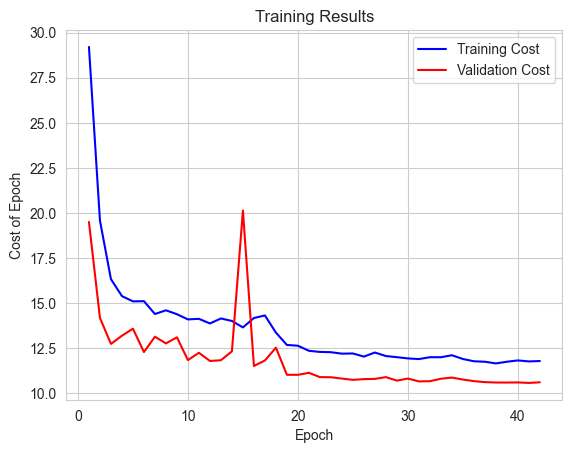

In [228]:
sns.lineplot(x=[*range(1,43)], y=train_losses, color="blue", label="Training Cost")
sns.lineplot(x=[*range(1,43)], y=val_losses, color="red", label="Validation Cost")
plt.title("Training Results")
plt.ylabel("Cost of Epoch")
plt.legend()
plt.xlabel("Epoch");

**Training Results**
* As expected, training loss is above validation loss (it happens because of dropout layers)
* After 20 epochs, loss stabilizes quite nicely (probably it converges to global minimum)
* Even through loss is kind of stabilized, training a bit linger would give us a at least small improvement (I could not continue training as I used cpu and it's quite time consuming)

In [229]:
torch.save(model.state_dict(), "weights/weights1.pt")

In [230]:
predictions = torch.Tensor([])
reals = torch.Tensor([])
test_loss = 0
model.eval()
with torch.no_grad():
    for n_batch, (x, y) in enumerate(test_dataloader):
        x, y = x.float(), y.float()
        preds = model(x)

        test_batch_loss = loss_fn(preds.squeeze(axis=-1), y)
        test_loss+=test_batch_loss
        predictions = torch.cat([preds, predictions])
        reals = torch.cat([y, reals])

In [231]:
predictions = predictions.squeeze(axis=-1)
predictions = predictions.numpy()
reals = reals.numpy()
predictions.shape, reals.shape

((57232,), (57232,))

In [232]:
pd.DataFrame(np.array([predictions, reals]).T[:20, :])

,0,1
0,13.200339,13.0
1,24.779680,23.5
2,6.647506,6.5
3,6.942578,7.0
4,12.297835,12.5
5,12.304389,13.0
6,30.966730,32.0
7,5.168853,5.0
8,10.081594,10.0
9,4.793125,4.0


* As we see, predictions are very close to real values